In [ ]:
#!pip install torchvision

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.__version__, torchvision.__version__

('1.7.0', '0.8.1')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [16]:
batch_size = 16

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
len(trainset.classes)

100

 deer      cat     bird     deer    airplane      dog      cat     ship


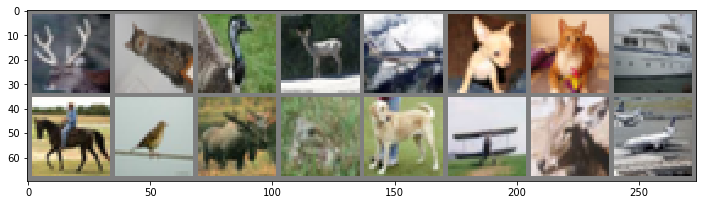

horse     bird     deer     frog      dog    airplane     deer    airplane


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    fig, ax = plt.subplots(figsize=(12, 4))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
print('    '.join('%5s' % trainset.classes[labels[j]] for j in range(0,int(batch_size/2))))
imshow(torchvision.utils.make_grid(images))
print('    '.join('%5s' % trainset.classes[labels[j]] for j in range(int(batch_size/2),batch_size)))

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 240)
        self.fc2 = nn.Linear(240, 168)
        self.fc3 = nn.Linear(168, len(trainset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [21]:
sample = next(iter(trainloader))

In [22]:
len(sample)

2

In [23]:
sample[0].shape, sample[1].shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

In [24]:
net(sample[0])

tensor([[-0.0332,  0.0939,  0.0652,  ..., -0.0812,  0.0631, -0.0331],
        [-0.0315,  0.0707,  0.0765,  ..., -0.0903,  0.0615, -0.0401],
        [-0.0242,  0.0843,  0.0802,  ..., -0.0958,  0.0599, -0.0385],
        ...,
        [-0.0362,  0.0703,  0.0778,  ..., -0.0818,  0.0614, -0.0377],
        [-0.0399,  0.0760,  0.0693,  ..., -0.0956,  0.0642, -0.0364],
        [-0.0376,  0.0696,  0.0755,  ..., -0.0934,  0.0700, -0.0295]],
       grad_fn=<AddmmBackward>)

In [26]:
num_epochs = 20

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 3.727
[2,  2000] loss: 3.473
[3,  2000] loss: 3.286
[4,  2000] loss: 3.123
[5,  2000] loss: 2.990


RuntimeError: DataLoader worker (pid 80730) is killed by signal: Unknown signal: 0. 